# Importing Data

We first define some utitlity functions to manipulate our datasets.

In [1]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def initialize_cache(data_dir: str) -> EcephysProjectCache:
    """
    Initialize the AllenSDK EcephysProjectCache object for the given data directory.
    """
    manifest_path = os.path.join(data_dir, "manifest.json")
    return EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [3]:
def get_session_data_from_sessionid(session_id: int, cache: EcephysProjectCache):
    """
    Get the EcephysSession object for the given session ID."
    """
    return cache.get_session_data(session_id)

In [4]:
def stimulus_spike_table(stimuli_table, columns, session, units):
    """
    Create a table of spike rates for each stimulus presentation and unit.
    """
    stimuli_ids = stimuli_table.index
    spikes_per_stimulus = session.presentationwise_spike_times(stimulus_presentation_ids = stimuli_ids)
    spikes_per_stimulus.reset_index(inplace=True)
    
    spike_counts = spikes_per_stimulus.groupby(['stimulus_presentation_id', 'unit_id'])['spike_time'].count().reset_index()
    spike_counts.rename(columns={'spike_time': 'spike_count'}, inplace=True)
    
    dataset = pd.merge(spike_counts, stimuli_table[columns + ['duration']], on='stimulus_presentation_id')
    dataset['spikes_per_second'] = dataset['spike_count'] / dataset['duration']
    dataset = dataset.drop(columns=['duration', 'spike_count'])
    dataset['area'] = units.loc[dataset['unit_id'], 'ecephys_structure_acronym'].values

    return dataset

In [5]:
def replace_not_recognized_nulls(dataset, drop_nan = False):
    """
    Replace all values that are not recognized with np.nan.
    Prints the number of replacements if any are found.
    """
    unrecognized_values = ['null', 'NULL', '', ' ']
    
    mask = dataset.isin(unrecognized_values)
    count = mask.sum().sum()  
    
    if count > 0:
        print(f"Replacing {count} unrecognized values with np.nan.")
    
    dataset = dataset.replace(unrecognized_values, np.nan)
    
    if drop_nan:
        dataset = dataset.dropna()
        print("Dropped rows containing NaN values.")

    return dataset

In [6]:
def count_units_by_area(all_areas, session_table, cache):
    """
    Returns a dictionary where the keys are session IDs, and the values are dictionaries of 
    brain areas with their respective unit counts for each session.
    """
    session_area_unit_counts = {}
    units = cache.get_units()
    
    for sid in session_table.index.values:
        session_counts = {}
        
        for area in all_areas:
            maskunits = (units["ecephys_session_id"] == sid) & (units["ecephys_structure_acronym"] == area)
            units_in_area = len(units[maskunits])
            
            session_counts[area] = units_in_area
        
        session_area_unit_counts[sid] = session_counts
    
    return session_area_unit_counts

In [7]:
def get_areas_from_session(session_id, cache):
    """
    Get a list of all brain areas with units in the given session.
    """
    units = cache.get_units()
    areas = units[units['ecephys_session_id'] == session_id]['ecephys_structure_acronym'].unique()
    return areas

In [8]:
def get_all_areas(cache):
    """
    Get a set (unique elements) of all brain areas with units in the dataset.
    """
    all_areas = set()
    for sid in cache.get_session_table().index.values:
        areas = get_areas_from_session(sid, cache)  
        all_areas.update(areas)
    return all_areas

In [9]:
def filter_sessions_by_numerical_column(session_table, column, min_value = 0, max_value = np.inf):
    """
    Filter the session table by a numerical column.
    """
    mask = (session_table[column] >= min_value) & (session_table[column] <= max_value)
    print(f"Filtered out {len(session_table) - mask.sum()} sessions.")
    return session_table[mask]

In [30]:
def compute_entropy(row):
    """
    Compute the entropy  H = -sum(p * log2(p)) of a distribution for a session.
    """
    counts = row.values

    total = counts.sum()
    # probabilities = counts / total if total > 0 else np.zeros_like(counts)
    probabilities = counts / total

    probabilities = probabilities[probabilities > 0]
    
    return -np.sum(probabilities * np.log2(probabilities))

## Sessions Analysis

Let us inspect some of the sessions in the dataset, trying to understand the count of the units we have per session.

In [11]:
data_dir = "./allendata"
cache = initialize_cache(data_dir)
session_table = cache.get_session_table()
session_table

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"
739448407,2019-10-03T00:00:00Z,716813543,brain_observatory_1.1,112.0,M,wt/wt,625,2221,6,"[grey, VISam, nan, VIS, VISp, VISl, VISrl]"
742951821,2019-10-03T00:00:00Z,723627604,brain_observatory_1.1,120.0,M,wt/wt,893,2219,6,"[VISal, nan, grey, VISl, VISrl, VISp, VISpm, VIS]"
743475441,2019-10-03T00:00:00Z,722882755,brain_observatory_1.1,121.0,M,wt/wt,553,2225,6,"[LP, LGd, HPF, DG, CA3, CA1, VISrl, nan, PP, P..."
744228101,2019-10-03T00:00:00Z,719817805,brain_observatory_1.1,122.0,M,wt/wt,659,2226,6,"[Eth, TH, LP, POL, APN, DG, CA1, VIS, nan, CA3..."


In [12]:
print("Number of sessions:", len(session_table))

Number of sessions: 58


Let's check the count for unit and probe in each session.
TODO add explanation

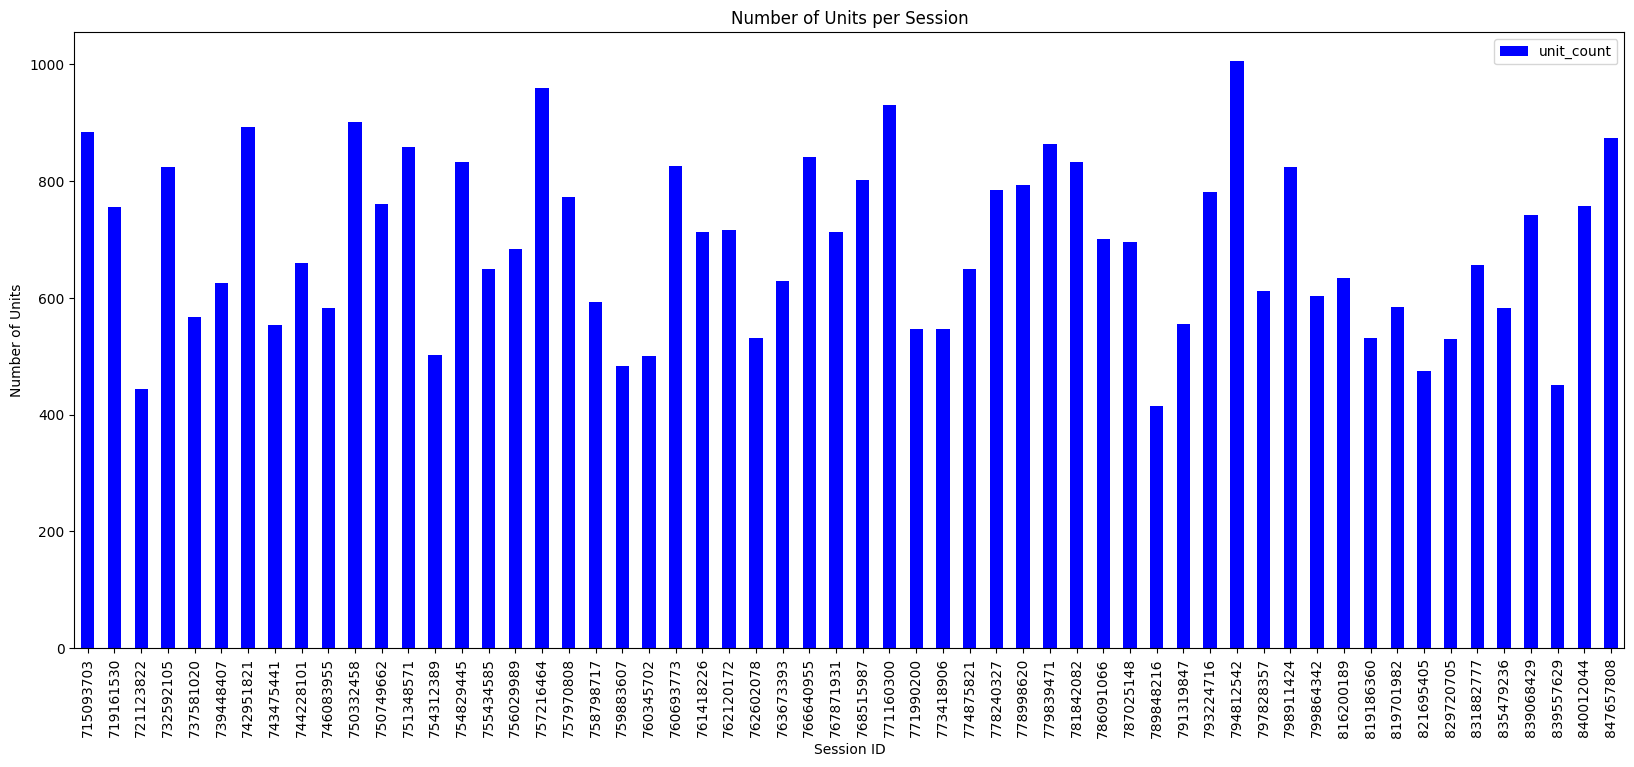

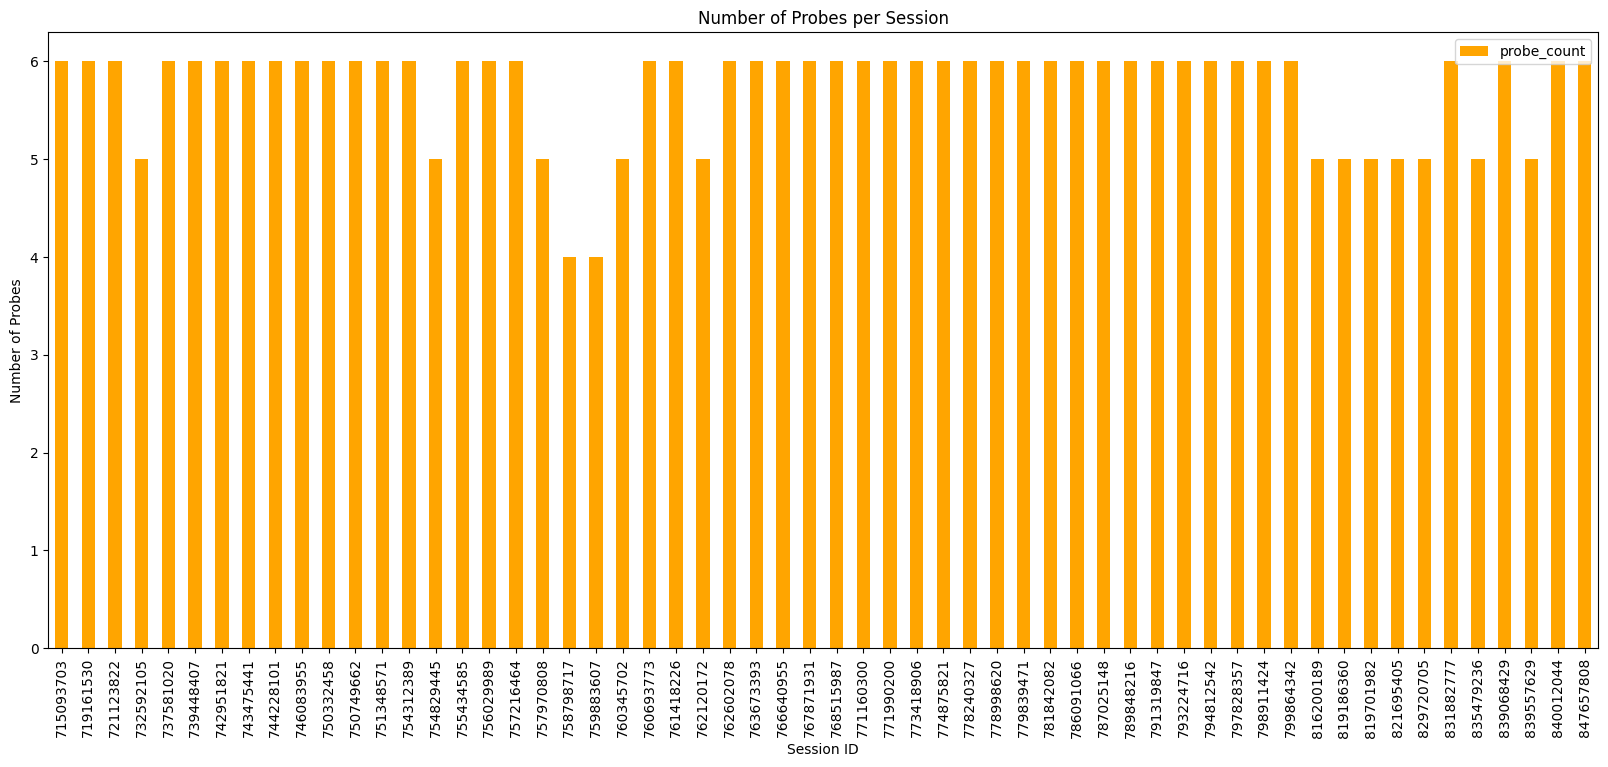

In [13]:
session_table.plot(kind='bar', y='unit_count', figsize=(20, 8), color='blue')
plt.xlabel('Session ID')
plt.ylabel('Number of Units')
plt.title('Number of Units per Session')
plt.show()

session_table.plot(kind='bar', y='probe_count', figsize=(20, 8), color='orange')
plt.xlabel('Session ID')
plt.ylabel('Number of Probes')
plt.title('Number of Probes per Session')
plt.show()

In [14]:
session_table = filter_sessions_by_numerical_column(session_table, column='probe_count', min_value=6)
print("Number of sessions after filtering:", len(session_table))

Filtered out 14 sessions.
Number of sessions after filtering: 44


We shall now focus of which units belong to certain areas of the brain.

In [15]:
all_areas = get_all_areas(cache)
print("Number of unique brain areas in the dataset:", len(all_areas))
print("Brain areas in the dataset:", all_areas)

Number of unique brain areas in the dataset: 53
Brain areas in the dataset: {'OP', 'MGd', 'LGd', 'VISmmp', 'PRE', 'SCig', 'LP', 'VISal', 'ProS', 'LGv', 'PPT', 'PoT', 'SCiw', 'NOT', 'CA3', 'PP', 'POST', 'VISli', 'VISpm', 'VIS', 'VPM', 'MRN', 'SUB', 'HPF', 'VPL', 'CA2', 'SCop', 'TH', 'grey', 'SCsg', 'POL', 'PIL', 'IGL', 'LT', 'Eth', 'PO', 'ZI', 'VISp', 'CA1', 'VISam', 'MGm', 'MB', 'RT', 'LD', 'VISmma', 'DG', 'VISl', 'VISrl', 'MGv', 'IntG', 'VL', 'APN', 'SGN'}


In [16]:
unit_count_by_area = count_units_by_area(all_areas, session_table, cache)
unit_count_by_area_df = pd.DataFrame(unit_count_by_area).T
unit_count_by_area_df

,OP,MGd,LGd,VISmmp,PRE,SCig,LP,VISal,ProS,LGv,...,LD,VISmma,DG,VISl,VISrl,MGv,IntG,VL,APN,SGN
715093703,0,0,82,0,0,0,139,0,0,0,...,0,0,26,42,76,0,0,0,26,0
719161530,0,0,71,0,0,0,28,9,0,0,...,0,0,14,40,10,0,0,7,176,0
721123822,0,0,0,0,0,10,69,37,0,11,...,0,0,41,27,46,0,0,0,10,0
737581020,0,0,0,0,0,0,0,0,0,0,...,0,16,0,22,67,0,0,0,0,0
739448407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,36,70,0,0,0,0,0
742951821,0,0,0,0,0,0,0,44,0,0,...,0,0,0,52,79,0,0,0,0,0
743475441,0,0,42,0,0,0,131,0,1,0,...,0,42,12,19,68,10,0,0,34,0
744228101,0,0,1,0,0,0,84,41,0,0,...,0,0,10,26,26,0,0,0,20,39
746083955,0,0,34,0,0,0,0,32,0,0,...,0,0,0,17,35,0,0,0,0,0
750332458,0,0,4,0,0,0,0,71,0,0,...,0,0,7,38,44,0,2,0,0,0


/var/folders/l4/fwn11xh17pb5ryvd5h_w9p8r0000gn/T/ipykernel_6158/3027083928.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_count_by_area_df_ordered["Other"] = unit_count_by_area_df_ordered[other_areas].sum(axis=1)


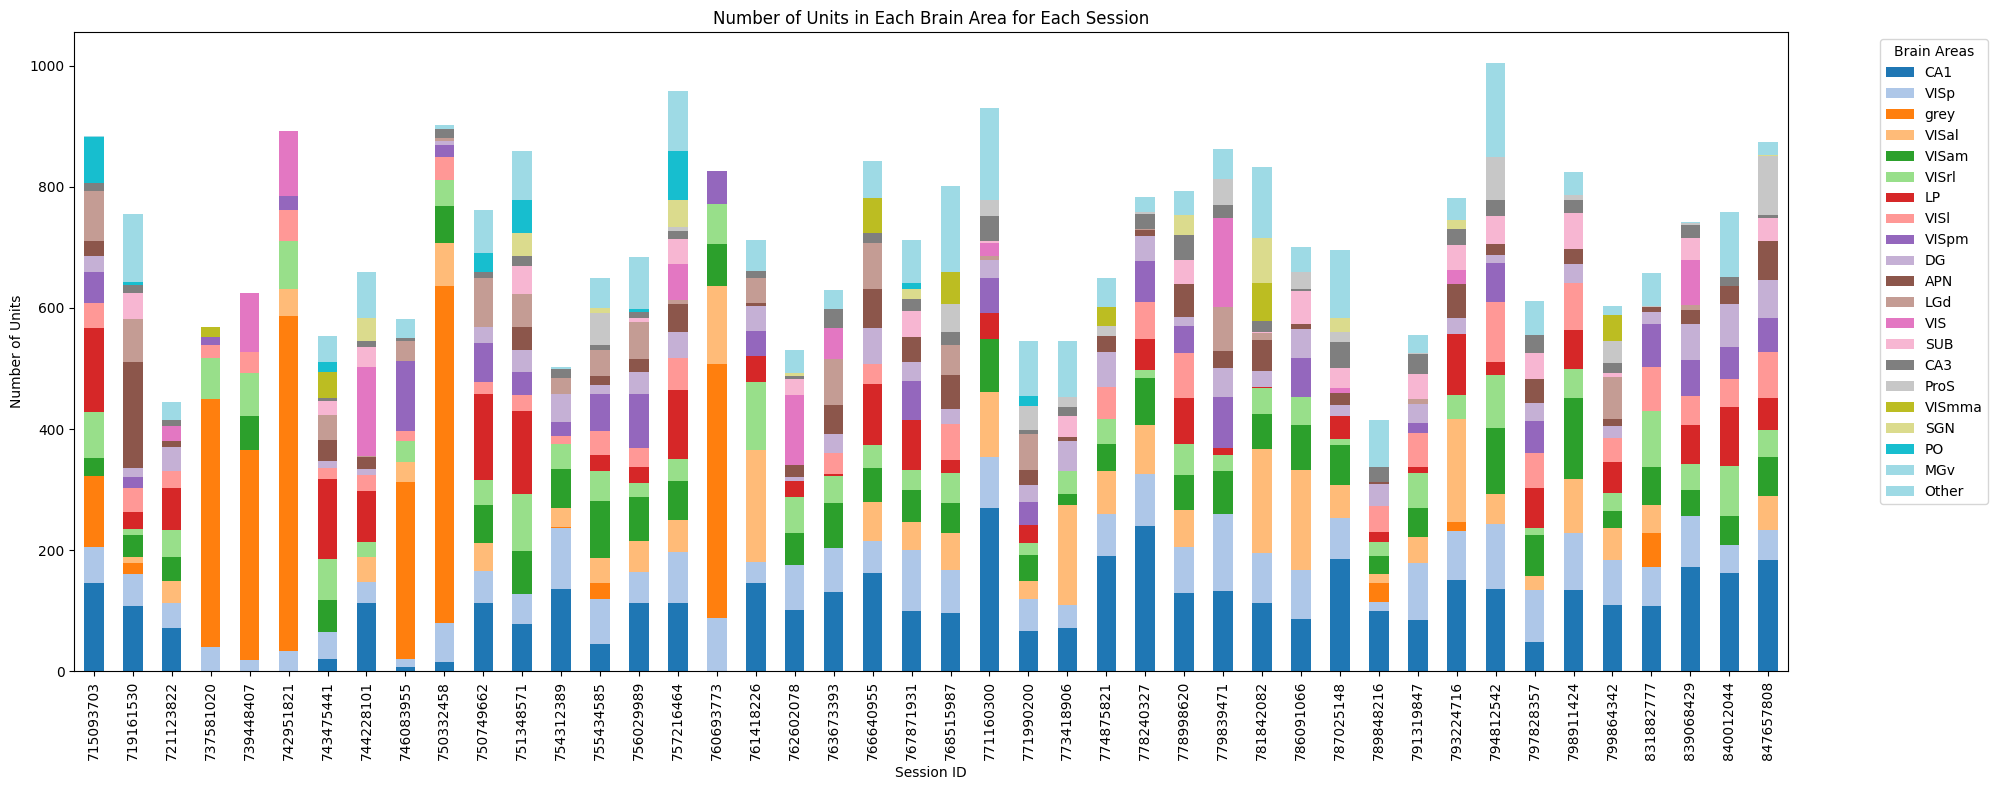

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))

column_order = unit_count_by_area_df.sum(axis=0).sort_values(ascending=False).index.tolist()
unit_count_by_area_df_ordered = unit_count_by_area_df[column_order]

top_areas = unit_count_by_area_df_ordered.columns[:20]  
other_areas = unit_count_by_area_df_ordered.columns[20:]

if len(other_areas) > 0:
    unit_count_by_area_df_ordered["Other"] = unit_count_by_area_df_ordered[other_areas].sum(axis=1)
    unit_count_by_area_df_ordered = unit_count_by_area_df_ordered[top_areas.tolist() + ["Other"]]

unit_count_by_area_df_ordered.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

ax.set_ylabel('Number of Units')
ax.set_xlabel('Session ID')
ax.set_title('Number of Units in Each Brain Area for Each Session')

plt.xticks(rotation=90)
ax.legend(title='Brain Areas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

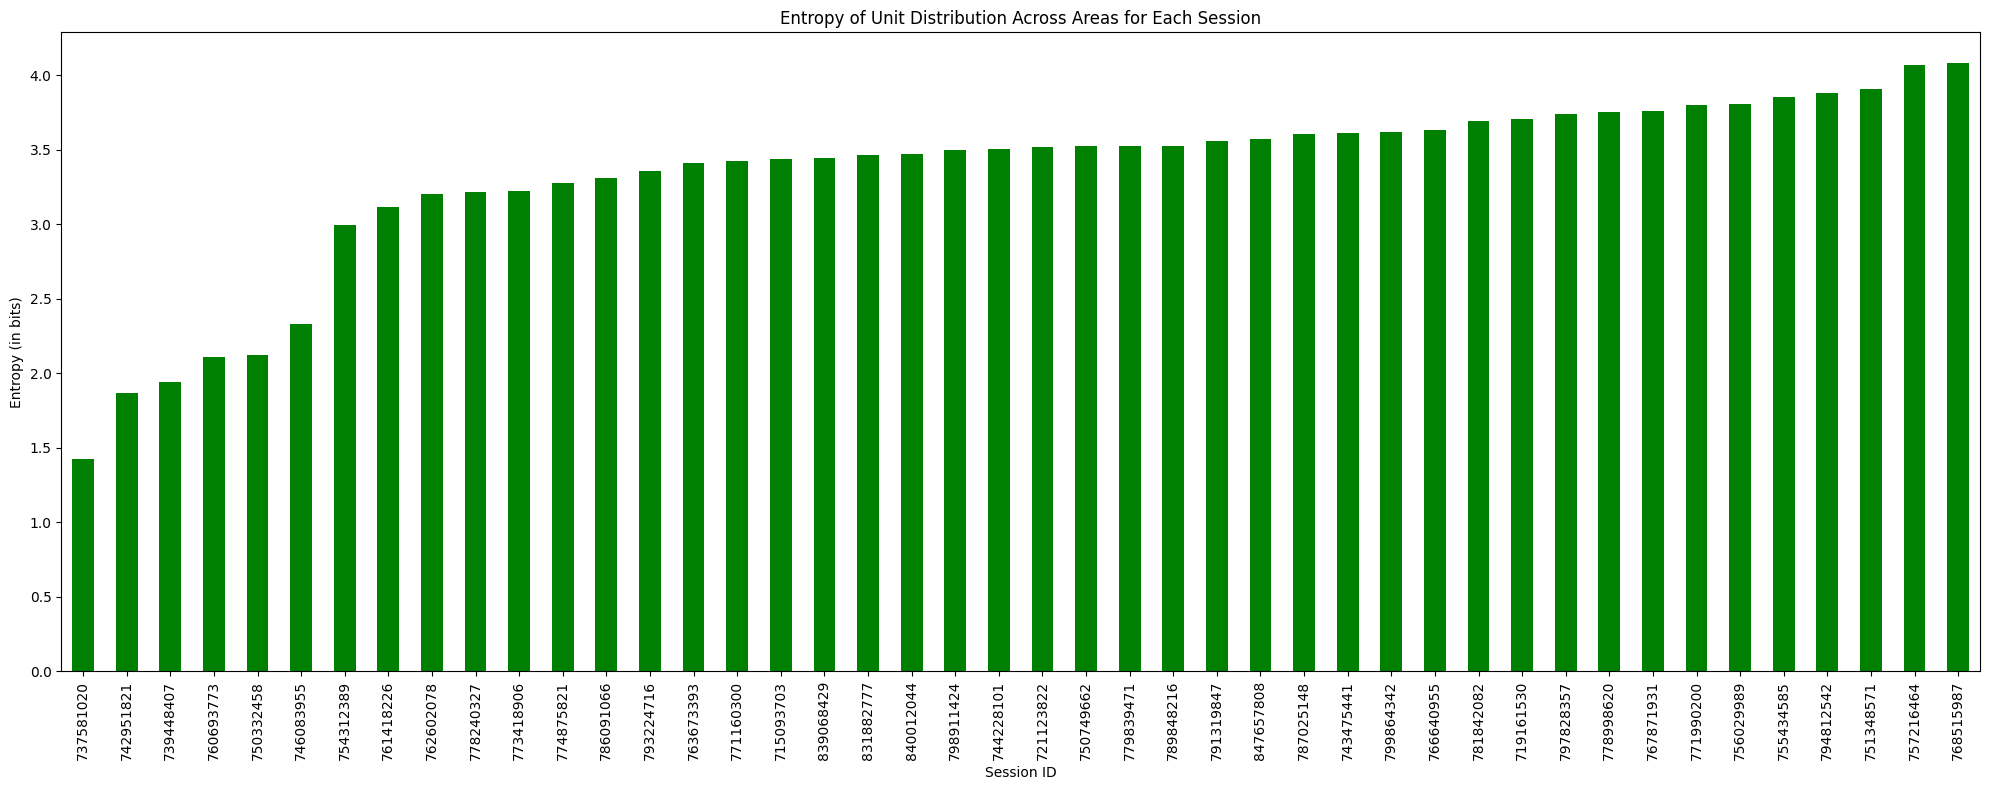

In [31]:
entropy_values = unit_count_by_area_df.apply(compute_entropy, axis=1)

fig, ax = plt.subplots(figsize=(20, 8))

entropy_values = entropy_values.sort_values()

entropy_values.plot(kind='bar', ax=ax, color='green')

ax.set_ylabel('Entropy (in bits)')
ax.set_xlabel('Session ID')
ax.set_title('Entropy of Unit Distribution Across Areas for Each Session')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [33]:
most_balanced_session = entropy_values.idxmax()
highest_entropy_value = entropy_values.max()

print(f"The most balanced session is {most_balanced_session} with an entropy of {highest_entropy_value:.4f}")

The most balanced session is 768515987 with an entropy of 4.0842


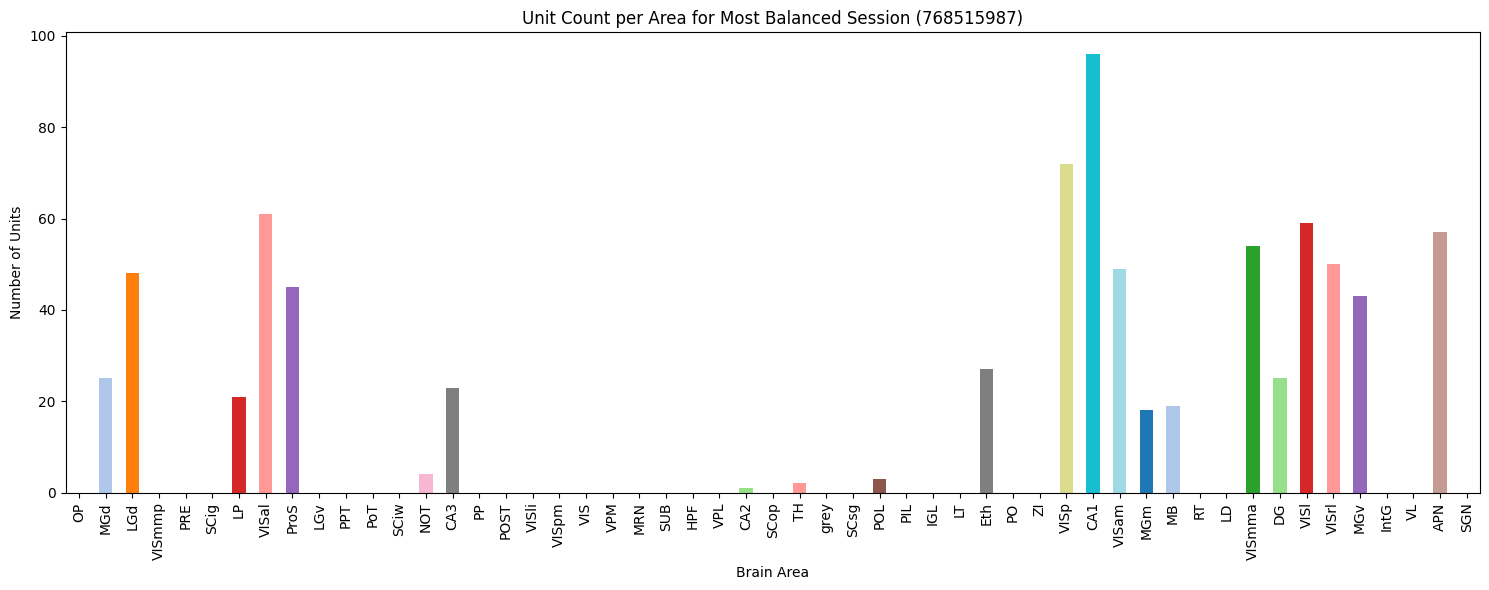

In [36]:
session_data = unit_count_by_area_df.loc[most_balanced_session]

colors = plt.cm.tab20.colors[:len(session_data)]

fig, ax = plt.subplots(figsize=(15, 6))
session_data.plot(kind='bar', ax=ax, color=colors, legend=False)

ax.set_ylabel('Number of Units')
ax.set_xlabel('Brain Area')
ax.set_title(f'Unit Count per Area for Most Balanced Session ({most_balanced_session})')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

## Data Loading

We initialize a cache from the previously defined function in the data directory of our repo.

From the column above "id" we select one session_id from which we get the session data.

In [21]:
session_id = 798911424
session = get_session_data_from_sessionid(session_id, cache)

/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [22]:
units = cache.get_units()
units

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cumulative_drift,d_prime,waveform_duration,ecephys_channel_id,firing_rate,waveform_halfwidth,isi_violations,...,phase,sampling_rate,has_lfp_data,date_of_acquisition,published_at,specimen_id,session_type,age_in_days,sex,genotype
id,,,,,,,,,,,,,,,,,,,,,
915956282,0.611816,164.878740,0.072728,309.71,3.910873,0.535678,850229419,6.519432,0.164824,0.104910,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956340,0.439372,247.254345,0.000881,160.24,5.519024,0.563149,850229419,9.660554,0.206030,0.006825,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956345,0.500520,251.275830,0.001703,129.36,3.559911,0.521943,850229419,12.698430,0.192295,0.044936,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956349,0.424620,177.115380,0.096378,169.29,2.973959,0.508208,850229419,16.192413,0.192295,0.120715,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956356,0.512847,214.954545,0.054706,263.01,2.936851,0.549414,850229419,2.193113,0.233501,0.430427,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951911942,0.368040,189.249060,0.001083,122.82,5.362617,0.631826,850103120,0.984659,0.192295,0.080230,...,3a,29999.958001,True,2018-10-31T17:39:23Z,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
951911948,0.660350,80.706600,0.000416,108.17,3.507884,0.302178,850103122,10.327972,0.233501,0.000365,...,3a,29999.958001,True,2018-10-31T17:39:23Z,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
951911955,0.357672,117.232440,0.023316,336.04,2.790057,0.714238,850103126,1.782535,0.192295,0.318256,...,3a,29999.958001,True,2018-10-31T17:39:23Z,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt


In [23]:
session.units.head()

/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: User

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951088679,0.620607,82.147455,0.023654,1,480.97,2.575648,7.429131,0.053350,51.364291,0.028062,...,215.0,APN,8328.0,3018.0,7095.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088664,0.587044,78.399165,0.001739,0,427.07,3.085334,6.843864,0.033732,40.358293,0.051513,...,215.0,APN,8328.0,3018.0,7095.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088734,0.560996,187.504005,0.001249,5,311.01,5.152564,1.418476,0.356931,56.950961,0.001292,...,215.0,APN,8316.0,2988.0,7099.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088721,0.474457,196.741545,0.000059,4,355.17,4.295014,11.517381,0.000271,58.358552,0.020218,...,215.0,APN,8316.0,2988.0,7099.0,probeA,See electrode locations,29999.965974,1249.998582,True
951088862,0.534674,92.125020,0.089901,16,239.50,4.043348,19.953126,0.013619,79.934237,0.011335,...,215.0,APN,8304.0,2958.0,7103.0,probeA,See electrode locations,29999.965974,1249.998582,True


In [24]:
session.metadata.keys()

/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: User

dict_keys(['specimen_name', 'session_type', 'full_genotype', 'sex', 'age_in_days', 'rig_equipment_name', 'num_units', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'session_start_time', 'ecephys_session_id', 'structure_acronyms', 'stimulus_names'])

In [25]:
session.metadata['stimulus_names']

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes',
 'drifting_gratings_contrast']

In [26]:
drifting_stimuli = session.get_stimulus_table('drifting_gratings')
drifting_stimuli.head()

,stimulus_block,start_time,stop_time,temporal_frequency,stimulus_name,phase,orientation,spatial_frequency,contrast,size,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,2.0,1586.180717,1588.182387,15.0,drifting_gratings,"[5308.98333333, 5308.98333333]",0.0,0.04,0.8,"[250.0, 250.0]",2.00167,246
3799,2.0,1589.183244,1591.184924,2.0,drifting_gratings,"[5308.98333333, 5308.98333333]",180.0,0.04,0.8,"[250.0, 250.0]",2.00168,247
3800,2.0,1592.185737,1594.187427,1.0,drifting_gratings,"[5308.98333333, 5308.98333333]",45.0,0.04,0.8,"[250.0, 250.0]",2.00169,248
3801,2.0,1595.188274,1597.189944,8.0,drifting_gratings,"[5308.98333333, 5308.98333333]",90.0,0.04,0.8,"[250.0, 250.0]",2.00167,249
3802,2.0,1598.190777,1600.192447,2.0,drifting_gratings,"[5308.98333333, 5308.98333333]",270.0,0.04,0.8,"[250.0, 250.0]",2.00167,250


In [27]:
static_stimuli = session.get_stimulus_table('static_gratings')
static_stimuli.head()

,stimulus_block,start_time,stop_time,stimulus_name,phase,orientation,spatial_frequency,contrast,size,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,
49434,8.0,5399.367847,5399.618056,static_gratings,0.5,150.0,0.02,0.8,"[250.0, 250.0]",0.250209,4787
49435,8.0,5399.618056,5399.868265,static_gratings,0.5,0.0,0.16,0.8,"[250.0, 250.0]",0.250209,4788
49436,8.0,5399.868265,5400.118474,static_gratings,0.25,30.0,0.04,0.8,"[250.0, 250.0]",0.250209,4789
49437,8.0,5400.118474,5400.368684,static_gratings,0.75,60.0,0.04,0.8,"[250.0, 250.0]",0.250209,4790
49438,8.0,5400.368684,5400.618889,static_gratings,0.0,60.0,0.08,0.8,"[250.0, 250.0]",0.250206,4791


In [28]:
drifting_dataset = stimulus_spike_table(drifting_stimuli, ['orientation', 'temporal_frequency'], session, units)
drifting_dataset.head()

,stimulus_presentation_id,unit_id,orientation,temporal_frequency,spikes_per_second,area
0,3798,951088664,0.0,15.0,12.489571,APN
1,3798,951088679,0.0,15.0,11.989988,APN
2,3798,951088721,0.0,15.0,12.489571,APN
3,3798,951088823,0.0,15.0,0.999166,APN
4,3798,951088862,0.0,15.0,38.967462,APN


In [29]:
static_dataset = stimulus_spike_table(static_stimuli, ['orientation', 'spatial_frequency'], session, units)
static_dataset.head()

KeyboardInterrupt: 

In [ ]:
drifting_dataset_clean = replace_not_recognized_nulls(drifting_dataset, drop_nan=True)
static_dataset_clean = replace_not_recognized_nulls(static_dataset, drop_nan=True)

Replacing 37284 unrecognized values with np.nan.
Dropped rows containing NaN values.
Replacing 165940 unrecognized values with np.nan.
Dropped rows containing NaN values.


In [ ]:
drifting_dataset_clean.head()

,stimulus_presentation_id,unit_id,orientation,temporal_frequency,spikes_per_second,area
0,3798,951088664,0.0,15.0,12.489571,APN
1,3798,951088679,0.0,15.0,11.989988,APN
2,3798,951088721,0.0,15.0,12.489571,APN
3,3798,951088823,0.0,15.0,0.999166,APN
4,3798,951088862,0.0,15.0,38.967462,APN


In [ ]:
static_dataset_clean.head()

,stimulus_presentation_id,unit_id,orientation,spatial_frequency,spikes_per_second,area
0,49434,951088664,150.0,0.02,11.989965,APN
1,49434,951088679,150.0,0.02,7.993310,APN
2,49434,951088721,150.0,0.02,31.973239,APN
3,49434,951088823,150.0,0.02,3.996655,APN
4,49434,951088862,150.0,0.02,19.983275,APN


In [ ]:
drifting_dataset_clean.to_parquet(f'ourdata/drifting_dataset_session_{session_id}.parquet')
static_dataset_clean.to_parquet(f'ourdata/static_dataset_session_{session_id}.parquet')

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.